# Multi Layer Perceptron
With `pytorch-lightning`

Creating a Multi Layer Peceptron (MLP) also know as a feed forward network

In [12]:
import torch
import torchmetrics
import torch.nn as nn
import torch.nn.functional as fn
# from torchsummary import summary

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pytorch_lightning as pl

Use GPU cuda if available, if not the cpu will be used

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Create train and test datasets
Creating train and test datasets of the MNIST data from pytorch. This data gets transformed to pytoch Tensors

In [14]:
train_dataset = torchvision.datasets.MNIST(
    root='./MNIST/data', 
    train=True, 
    transform=transforms.ToTensor(),
    download=True)

test_dataset = torchvision.datasets.MNIST(
    root='./MNIST/data', 
    train=False, 
    transform=transforms.ToTensor(),
    download=True)

## Create train and test dataloaders
Creating train and test dataloaders

In [15]:
batch_size = 64

# Create training dataloader
train_dl = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Create test dataloader
test_dl = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Printed out the amount of samples that a batch will return, with the amount of channels, width and height of the image.

torch.Size([64, 1, 28, 28]) torch.Size([64])


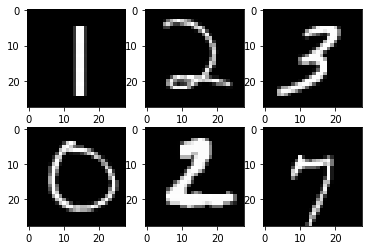

In [16]:
examples_iter = iter(train_dl)
examples, examples_labels = examples_iter.next()

print(examples.shape, examples_labels.shape)

# Plot examples of the data
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(examples[i][0], cmap='gray')
plt.show()

## Create model

In [17]:
learning_rate = 0.003

class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.configure_metrics()
        self.loss_func = nn.CrossEntropyLoss()
        # Create Linear layer
        self.l1 = nn.Linear(28 * 28, 512)
        # Set activation function
        self.relu = nn.ReLU()
        # Set ouput layer
        self.l2 = nn.Linear(512, 10)
    
    def forward(self, x):
        # Reshape images because shape is [100, 1, 28, 28] and it needs to become [100, 784] the same as the input size of the model
        x = x.reshape(-1, 28*28)
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        # Forward == model(x)
        output = self(x)
        loss = self.loss_func(output, y)
        self.train_acc(output, y)
        self.log('train_acc', self.train_acc)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        # Forward == model(x)
        output = self(x)
        loss = self.loss_func(output, y)
        self.valid_acc(output, y)
        self.log('val_acc', self.valid_acc)
        self.log('val_loss', loss)

    def backward(self, loss, optimizer, optimizer_idx):
        loss.backward()
    
    def configure_metrics(self):
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()


model = MultiLayerPerceptron()

In [18]:
trainer = pl.Trainer(max_epochs=4)
trainer.fit(model, train_dl, test_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | train_acc | Accuracy         | 0     
1 | valid_acc | Accuracy         | 0     
2 | loss_func | CrossEntropyLoss | 0     
3 | l1        | Linear           | 401 K 
4 | relu      | ReLU             | 0     
5 | l2        | Linear           | 5.1 K 
-----------------------------------------------
407 K     Trainable params
0         Non-trainable params
407 K     Total params
1.628     Total estimated model params size (MB)


Epoch 3: 100%|██████████| 1095/1095 [00:32<00:00, 33.39it/s, loss=0.0426, v_num=2]
